In [78]:
from preprocess import *

from sklearn.metrics import classification_report, accuracy_score
from sklearn.naive_bayes import MultinomialNB

In [79]:
X_train = training_df[input_features]
y_train = training_df['sentiment']

X_test = test_df[input_features]
y_test = test_df['sentiment']

model = MultinomialNB()
model.fit(X_train, y_train)

MultinomialNB()

In [80]:
y_pred = model.predict(X_test)

In [81]:
accuracy = accuracy_score(y_test, y_pred)

print("Accuracy:", accuracy)

Accuracy: 0.810125


In [82]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.88      0.82      4000
           1       0.86      0.74      0.80      4000

    accuracy                           0.81      8000
   macro avg       0.82      0.81      0.81      8000
weighted avg       0.82      0.81      0.81      8000



In [83]:
# predict unseen data
new_data = [
    'Have no fun',
    'good',
    'bad',
    'interesting',
    'blah blah',
    "The product was amazing! I loved it.",
    "Terrible experience, would not recommend.",
    "Great value for the price.",
    "Disappointed with the quality.",
    "This exceeded my expectations.",
    "Worst purchase ever!",
    "Highly recommended, will buy again.",
    "Not worth the money.",
    "The service was excellent.",
    "Very poor customer service."
]
predictions = model.predict(preprocess(new_data)[input_features])
for i in range(0, len(new_data)):
    print(f'{new_data[i]}: {predictions[i]}')

Have no fun: 1
good: 1
bad: 0
interesting: 1
blah blah: 0
The product was amazing! I loved it.: 1
Terrible experience, would not recommend.: 0
Great value for the price.: 1
Disappointed with the quality.: 0
This exceeded my expectations.: 1
Worst purchase ever!: 0
Highly recommended, will buy again.: 1
Not worth the money.: 1
The service was excellent.: 1
Very poor customer service.: 0


In [84]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [85]:
# Define parameter distributions
param_dist = {
    'alpha': [0.1, 0.5, 1.0, 1.5, 2.0],  
    'fit_prior': [True, False],
    'class_prior': [[0.3, 0.7], [0.5, 0.5], [0.2, 0.8], [0.6, 0.4], [0.8, 0.2]] 
}

# Create Multinomial Naive Bayes classifier
model = MultinomialNB()

# Perform randomized search
random_search = RandomizedSearchCV(model, param_dist, n_iter=10, cv=5, scoring='accuracy', n_jobs=-1, random_state=42)
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=MultinomialNB(), n_jobs=-1,
                   param_distributions={'alpha': [0.1, 0.5, 1.0, 1.5, 2.0],
                                        'class_prior': [[0.3, 0.7], [0.5, 0.5],
                                                        [0.2, 0.8], [0.6, 0.4],
                                                        [0.8, 0.2]],
                                        'fit_prior': [True, False]},
                   random_state=42, scoring='accuracy')

In [86]:
random_search.best_params_

{'fit_prior': False, 'class_prior': [0.5, 0.5], 'alpha': 0.5}

In [87]:
random_search.best_score_

0.8126875

In [88]:
final_model = MultinomialNB(**random_search.best_params_)
final_model.fit(X_train, y_train)

# Evaluate final model
y_pred = final_model.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.810125


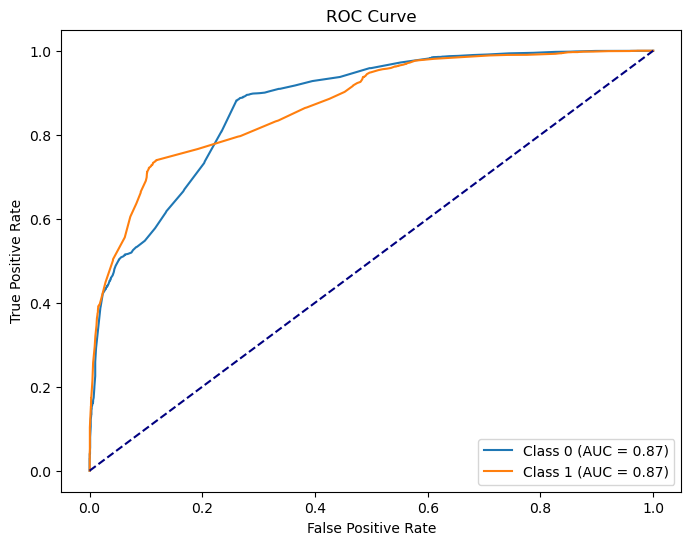

In [89]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Get predicted probabilities for each class
y_prob = random_search.predict_proba(X_test)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(random_search.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_test == random_search.classes_[i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(8, 6))
for i in range(len(random_search.classes_)):
    plt.plot(fpr[i], tpr[i], label=f'Class {random_search.classes_[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [90]:
# Define parameter distributions
param_grid = {
    'alpha': [0.1, 0.5, 1.0, 1.5, 2.0],  
    'fit_prior': [True, False],
    'class_prior': [[0.3, 0.7], [0.5, 0.5], [0.2, 0.8], [0.6, 0.4], [0.8, 0.2]] 
}

# Create Multinomial Naive Bayes classifier
model = MultinomialNB()

# Perform randomized search
grid_search = GridSearchCV(model, param_dist, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=MultinomialNB(), n_jobs=-1,
             param_grid={'alpha': [0.1, 0.5, 1.0, 1.5, 2.0],
                         'class_prior': [[0.3, 0.7], [0.5, 0.5], [0.2, 0.8],
                                         [0.6, 0.4], [0.8, 0.2]],
                         'fit_prior': [True, False]},
             scoring='accuracy')

In [91]:
grid_search.best_score_

0.8126875

In [92]:
grid_search.best_params_

{'alpha': 0.1, 'class_prior': [0.5, 0.5], 'fit_prior': True}

In [93]:
grid_model = MultinomialNB(**grid_search.best_params_)
grid_model.fit(X_train, y_train)

# Evaluate final model
y_pred = grid_model.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.810125


In [94]:
grid_model = MultinomialNB(alpha=best_params['alpha'], fit_prior=best_params['fit_prior'], class_prior=best_params['class_prior'])
grid_model.fit(X_train, y_train)

# Evaluate final model
y_pred = grid_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.88      0.82      4000
           1       0.86      0.74      0.80      4000

    accuracy                           0.81      8000
   macro avg       0.82      0.81      0.81      8000
weighted avg       0.82      0.81      0.81      8000



In [95]:
model = MultinomialNB(**clf.best_params_)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.810125


In [96]:
import pickle

with open('exported_models/multinomial.pkl', 'wb') as f:
    pickle.dump(model, f)

In [97]:
import pickle 

with open('exported_models/multinomial.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

In [98]:
loaded_model.predict(X_test)

array([1, 1, 1, ..., 0, 0, 0])